Importation des librairies :

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Création d'une fonction afin de charger les données d'un restaurant entre 2 semaines :

In [20]:
def extract(data_dir, prefix, start_week, end_week):
    """
    Extract a temporal slice of data for a given data source
    
    Prameters
    ---------
    data_dir : str
        Data directory path
    start_week : int
        First week number (inclued)
    end_week : int
        Last week number (inclued)
    prefix : str
        Data source identification (e.g. restaurant_1)
    """

    df = pd.DataFrame()

    for i in range(start_week, end_week+1): # end_week + 1 pour prendre jusqu'au dernier
        file_path = os.path.join(data_dir, 'data', f'{prefix}_week_{i}.csv') # Charger le fichier

        if os.path.isfile(file_path):  # on vérifie si le fichier existe
            batch = pd.read_csv(file_path)
            df = pd.concat([df, batch], sort=True)

        return df

Exemple d'excéution de la fonction :

In [21]:
df = extract(data_dir = "/Users/147843/TP_MLOps", prefix = "restaurant_1", start_week = 108, end_week = 110)

In [22]:
df.head()

,Item Name,Order Date,Order Number,Product Price,Quantity,Total products
0,Mango Chutney,2017-01-28 19:14:00,4416,0.5,3,4
1,Mango Chutney,2017-01-28 18:41:00,4414,0.5,1,13
2,Mint Sauce,2017-01-28 18:41:00,4414,0.5,1,13
3,Mango Chutney,2017-01-28 18:28:00,4413,0.5,1,6
4,Mango Chutney,2017-01-28 12:32:00,4402,0.5,1,10


Création d'une fonction pour nettoyer les données :

In [44]:
def clean(df):
    """Clean dataframe."""
    
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df['order_date'] = pd.to_datetime(df['order_date'])
    df = df.rename(columns={'order_number': 'order_id'})
    df = df.sort_values('order_date')
    df['total_product_price'] = df['quantity'] * df['product_price']
    df['cash_in'] = df.groupby('order_id')['total_product_price'].transform(np.sum)
    df = df.drop(columns=['item_name', 'quantity', 'product_price', 
                          'total_products', 'total_product_price'],
                errors="ignore")
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

Exemple d'exécution de la fonction :

In [49]:
clean(df)

,order_date,order_id,cash_in
0,2017-01-23 16:54:00,4347,44.65
1,2017-01-23 17:52:00,4348,29.00
2,2017-01-23 18:15:00,4349,26.30
3,2017-01-23 19:11:00,4350,22.70
4,2017-01-23 19:12:00,4351,26.70
...,...,...,...
70,2017-01-28 20:40:00,4419,72.05
71,2017-01-28 22:29:00,4420,54.70
72,2017-01-29 18:53:00,4422,60.50
73,2017-01-29 20:22:00,4423,33.70


Création d'une fonction pour fusionner des dataframes :

In [60]:
def merge(df1, df2):
    df = pd.concat([df1, df2])
    df = df.drop(columns = ['order_id'])
    df = df.sort_values('order_date')
    df = df.reset_index(drop=True)
    return df

Création d'une fonction pour l'heure :

In [63]:
def resample(df): 
    df = df.resample('1H', on='order_date').sum().reset_index()
    return df

Restaurant 1 :

In [54]:
df1 = extract(data_dir = "/Users/147843/TP_MLOps", prefix = "restaurant_1", start_week = 108, end_week = 110)
df1 = clean(df1)
df1

,order_date,order_id,cash_in
0,2017-01-23 16:54:00,4347,44.65
1,2017-01-23 17:52:00,4348,29.00
2,2017-01-23 18:15:00,4349,26.30
3,2017-01-23 19:11:00,4350,22.70
4,2017-01-23 19:12:00,4351,26.70
...,...,...,...
70,2017-01-28 20:40:00,4419,72.05
71,2017-01-28 22:29:00,4420,54.70
72,2017-01-29 18:53:00,4422,60.50
73,2017-01-29 20:22:00,4423,33.70


Restaurant 2 :

In [53]:
df2 = extract(data_dir = "/Users/147843/TP_MLOps", prefix = "restaurant_2", start_week = 108, end_week = 110)
df2 = clean(df2)
df2

,order_date,order_id,cash_in
0,2017-01-23 16:01:00,7814,35.75
1,2017-01-23 17:33:00,7815,37.70
2,2017-01-23 18:07:00,7816,37.70
3,2017-01-23 19:18:00,7817,98.35
4,2017-01-23 19:46:00,7818,18.70
...,...,...,...
103,2017-01-29 19:18:00,7929,42.60
104,2017-01-29 19:24:00,7930,26.90
105,2017-01-29 20:09:00,7931,20.80
106,2017-01-29 20:45:00,7932,16.80


In [61]:
df = merge(df1, df2)

In [64]:
df = resample(df)

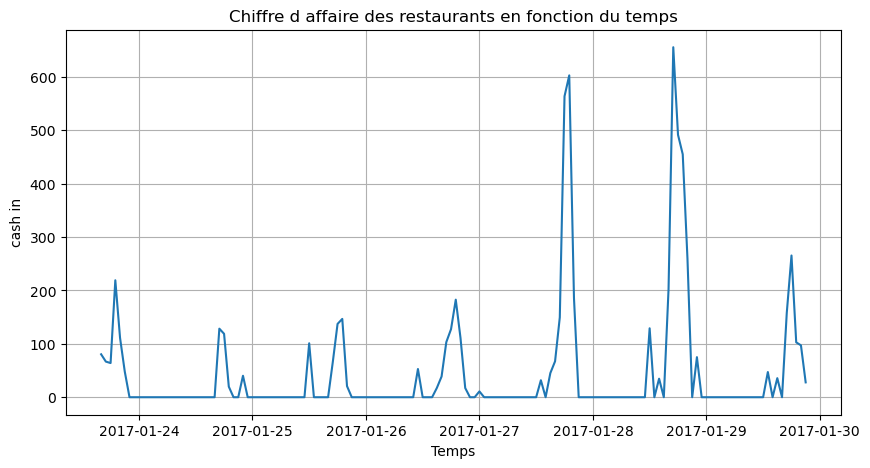

In [67]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(df['order_date'], df['cash_in'])
ax.set_title('Chiffre d affaire des restaurants en fonction du temps')
ax.set_xlabel('Temps')
ax.set_ylabel('cash in')
plt.grid(True)